In [46]:
import sys
import os

import numpy as np
import scipy as sp
#import scipy.signal as sig

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import matplotlib.cm as cm

import cvxopt

import cvxpy as cvx

%matplotlib notebook


status: optimal
optimal value 5485.82268841
(2, 10)


<IPython.core.display.Javascript object>


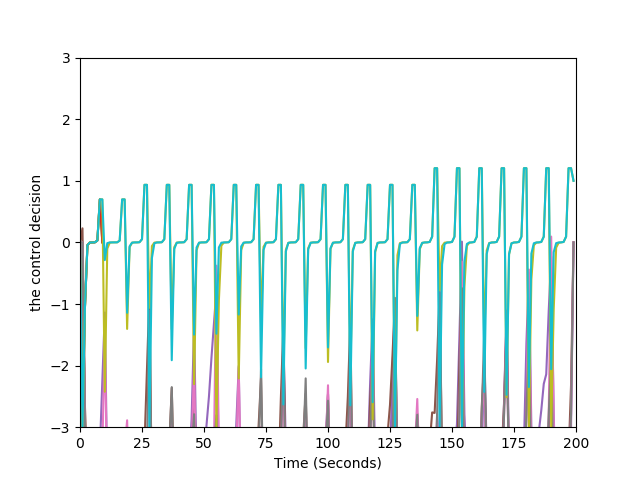

In [47]:
T = 10 # seconds, the time horizon of optimisation 
dt = 1 #seconds, the time step of optimisation 

#size of the storage for all the values of different signals
ssize = int(T/dt) 

# x_i is added as a vector of variables to the problem 
x_pred = cvx.Variable(  2,ssize )



# u_i is added as a vector of variables to the problem 
u_plan = cvx.Variable( 2,ssize)

# adding the state space constraints  
constraints = [ ]

#adding the initial conditions
constraints.append (x_pred[:,0] == [0,0])
constraints.append (u_plan[:,0] == [0,0])

constraints.append (x_pred <= 10)
constraints.append (x_pred >= -10)

constraints.append (u_plan <= 3)
constraints.append (u_plan >= -3)


for i in range (ssize-1):
    constraints.append (x_pred[:,i+1] == x_pred[:,i] + u_plan[:,i])
    
    

# the time-varying part of cost
m = 20


# objective function
ObjFunc =   cvx.Minimize(  sum(
                                cvx.norm(1* u_plan[:,i], 2)**2 +
                                2 * cvx.norm(x_pred[:,i]-[5,5],2)**2 +
                                m * cvx.norm(x_pred[:,i]-[-5,-5],2)**2
                           for i in range(ssize)) + 
                           2 * cvx.norm(x_pred[:,-1]-[5,5],2)**2 
                        )

prob = cvx.Problem(ObjFunc, constraints)
prob.solve() 
print "status:", prob.status
print "optimal value", prob.value
print np.shape(x_pred.value)

plt.plot(x_pred.value.T )
plt.ylabel('Predicted state')
plt.xlabel('Time (Seconds)')
plt.axis([0, ssize, -10, 10])
plt.show()

plt.plot(u_plan.value.T)
plt.ylabel('Control Decision')
plt.xlabel('Time (Seconds)')
plt.axis([0, ssize, -4, 4])
plt.show()





## MPC Strategy 


In [48]:


# actual simulation time horizon 
T_Sim = 200

# size of the storage variables dt is the same as the time step for point optimisation
size_Sim = int (T_Sim/dt )

# the horizon for planning/optimisation
T_Opt = 10

# initialising the storage array for the variables of the problem
x_sim = np.zeros((2, size_Sim))
x_sim_0  = np.zeros((1, 2))
x_sim[:,0] = x_sim_0 


x_pred_sim = np.zeros((2, size_Sim))
x_pred_sim_0  = np.zeros((1, 2))
x_pred_sim[:,0] = x_pred_sim_0 

u_sim = np.ones((2, size_Sim))
u_sim_0  = np.zeros((1, 2))
u_sim[:,0] = u_sim_0 

# u_plan_sim = [[0],[0]] * size_Sim
# u_plan_sim_0  = [[0],[0]]
# u_plan_sim[:,0] = u_plan_sim_0 


# this is the main loop of the simulation 
i = 0
while (i <= size_Sim - T_Opt - 1):
    
    
    # replace the initial conditions for the solver
    

    prob.constraints[0] = (x_pred[0,0] == x_sim[0,i])
    prob.constraints[1] = (x_pred[1,0] == x_sim[1,i])
    prob.constraints[2] = (u_plan[0,0] == u_sim[0,i])
    prob.constraints[3] = (u_plan[1,0] == u_sim[1,i])

    
    
    
    
    #solve for the next N steps
    prob.solve()
    
    # this is the execution loop of the simulation in which for T_Opt steps
    # the plan of the planner is applied to the simulated system
    for j in range (T_Opt - 1):
        
        
        #reading the plan from the solver 
        u_sim[:,i+j] = (u_plan.value[:,j]).T
        
        
        #disturbance signal randint returns uniformly probable an integer between [lower upper) upper not included.  
        d = np.random.uniform(-.5,.6,[1,2]) 
        
        
        # how the actual system is simulated 
        x_sim[:,i+j+1] = x_sim[:,i+j] + u_sim[:,i+j] + d 
        
        
        
        # storing what the planner had predicted for the states
        print i,j,  np.shape(x_pred_sim), np.shape(x_pred.value) 
        x_pred_sim[:,i+j+1] = (x_pred.value[:,j+1]).T
        
        
    
    # house keeping for the interplay of the inner and outer loop (you can ignore these)
    i = i + T_Opt - 1    
    u_sim[:,i] = u_sim[:,i - 1]
    print np.linalg.norm(x_sim[:,i]-[-5,-5],2)
    
    if (np.linalg.norm(x_sim[:,i]-[-5,-5],2) < 2):
        m= m -5
        prob.objective =  cvx.Minimize (sum(
                                cvx.norm(1* u_plan[:,k], 2)**2 +
                                1* cvx.norm(x_pred[:,k]-[5,5],2)**2 +
                                m * cvx.norm(x_pred[:,k]-[-5,-5],2)**2
                           for k in range(ssize)) + 
                           2 * cvx.norm(x_pred[:,-1]-[5,5],2)**2 )
                        
    
    
    





0 0 (2, 200) (2, 10)
0 1 (2, 200) (2, 10)
0 2 (2, 200) (2, 10)
0 3 (2, 200) (2, 10)
0 4 (2, 200) (2, 10)
0 5 (2, 200) (2, 10)
0 6 (2, 200) (2, 10)
0 7 (2, 200) (2, 10)
0 8 (2, 200) (2, 10)
2.78771104365
9 0 (2, 200) (2, 10)
9 1 (2, 200) (2, 10)
9 2 (2, 200) (2, 10)
9 3 (2, 200) (2, 10)
9 4 (2, 200) (2, 10)
9 5 (2, 200) (2, 10)
9 6 (2, 200) (2, 10)
9 7 (2, 200) (2, 10)
9 8 (2, 200) (2, 10)
1.81467497323
18 0 (2, 200) (2, 10)
18 1 (2, 200) (2, 10)
18 2 (2, 200) (2, 10)
18 3 (2, 200) (2, 10)
18 4 (2, 200) (2, 10)
18 5 (2, 200) (2, 10)
18 6 (2, 200) (2, 10)
18 7 (2, 200) (2, 10)
18 8 (2, 200) (2, 10)
3.0689331527
27 0 (2, 200) (2, 10)
27 1 (2, 200) (2, 10)
27 2 (2, 200) (2, 10)
27 3 (2, 200) (2, 10)
27 4 (2, 200) (2, 10)
27 5 (2, 200) (2, 10)
27 6 (2, 200) (2, 10)
27 7 (2, 200) (2, 10)
27 8 (2, 200) (2, 10)
2.08312476284
36 0 (2, 200) (2, 10)
36 1 (2, 200) (2, 10)
36 2 (2, 200) (2, 10)
36 3 (2, 200) (2, 10)
36 4 (2, 200) (2, 10)
36 5 (2, 200) (2, 10)
36 6 (2, 200) (2, 10)
36 7 (2, 200) (2,

In [49]:
# Plotting the results
plt.plot(x_sim.T)
plt.ylabel('state of simulated system')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, -10, 10])
plt.show()

plt.plot(x_pred_sim.T)
plt.ylabel('state of the system as predicted by Planner')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, -10, 10])
plt.show()

plt.plot(u_sim.T)
plt.ylabel('the control decision')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, -3, 3])
plt.show()



<IPython.core.display.Javascript object>


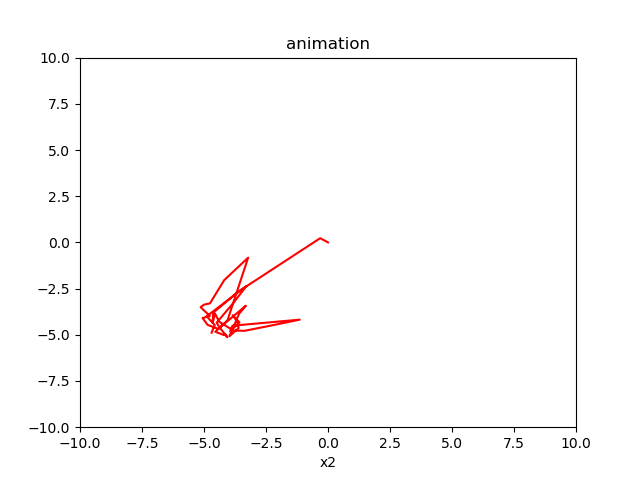

In [50]:
# Animation 





def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

fig2 = plt.figure()


data = x_sim

l, = plt.plot([], [], 'r-')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('x1')
plt.xlabel('x2')
plt.title('animation')

line_ani = animation.FuncAnimation(fig2, update_line, size_Sim, fargs=(data, l),
                                   interval=100, blit=True)
#HTML(line_ani.to_jshtml())